In [ ]:
import numpy as np
import os
import copy
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"violettazarubayko","key":"a519d96c7375e315664e93c0cbed538e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d imbikramsaha/food11

Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/food11
License(s): CC0-1.0
 96% 499M/519M [00:05<00:00, 91.0MB/s]
100% 519M/519M [00:05<00:00, 107MB/s] 


In [ ]:
!unzip food11.zip -d /content/food11

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/food11/food11/train/hamburger/2722745.jpg  
  inflating: /content/food11/food11/train/hamburger/272642.jpg  
  inflating: /content/food11/food11/train/hamburger/2726558.jpg  
  inflating: /content/food11/food11/train/hamburger/2738245.jpg  
  inflating: /content/food11/food11/train/hamburger/2745577.jpg  
  inflating: /content/food11/food11/train/hamburger/2745917.jpg  
  inflating: /content/food11/food11/train/hamburger/2754513.jpg  
  inflating: /content/food11/food11/train/hamburger/2756964.jpg  
  inflating: /content/food11/food11/train/hamburger/2762170.jpg  
  inflating: /content/food11/food11/train/hamburger/2766731.jpg  
  inflating: /content/food11/food11/train/hamburger/2771605.jpg  
  inflating: /content/food11/food11/train/hamburger/277584.jpg  
  inflating: /content/food11/food11/train/hamburger/2777938.jpg  
  inflating: /content/food11/food11/train/hamburger/2790429.jpg  
  inflatin

In [ ]:
!ls /content/dataset/food11

test  train


In [ ]:
DATA_DIR = '/content/dataset/food11'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

BATCH_SIZE = 32
NUM_CLASSES = 11

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def build_enum_dir(root_dir):
    """
    Создаёт список кортежей (имя_папки, индекс)
    на основе поддиректорий в root_dir.
    """
    folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    return [(folder, idx) for idx, folder in enumerate(folders)]

enum_dir = build_enum_dir(TRAIN_DIR)
print("📂 Найдены классы:")
for name, idx in enum_dir:
    print(f"{idx}: {name}")


def scan_and_clean_data(root_dir):
    """
    Сканирует корневую директорию с изображениями, автоматически определяет классы по именам подпапок,
    проверяет корректность файлов и возвращает пути к изображениям и их метки.

    Для каждой подпапки в `root_dir` создаётся уникальный числовой индекс (начиная с 0).
    Из каждой папки выбираются только корректные изображения форматов `.jpg` и `.jpeg`.
    """
    image_paths = []
    labels = []

    for label_name, label_id in enum_dir:
        path = os.path.join(root_dir, label_name)

        for filename in tqdm(os.listdir(path), desc=f"{label_name}"):
            file_path = os.path.join(path, filename)

            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            try:
                img = Image.open(file_path)
                img.load()

                if img.mode not in ('RGB', 'L'):
                    continue

                image_paths.append(file_path)
                labels.append(label_id)
            except Exception:
                continue

    print(f"total {len(labels)}")
    for label_name, label_id in enum_dir:
        count = labels.count(label_id)
        print(f"{label_name:15s}: {count}")

    return image_paths, labels


for t in ['test', 'train']:
    print(f"\nПапка {t}")
    scan_and_clean_data(os.path.join(DATA_DIR, t))

📂 Найдены классы:
0: apple_pie
1: cheesecake
2: chicken_curry
3: french_fries
4: fried_rice
5: hamburger
6: hot_dog
7: ice_cream
8: omelette
9: pizza
10: sushi

Папка test


sushi: 100%|██████████| 100/100 [00:00<00:00, 289661.88it/s]


total 0
apple_pie      : 0
cheesecake     : 0
chicken_curry  : 0
french_fries   : 0
fried_rice     : 0
hamburger      : 0
hot_dog        : 0
ice_cream      : 0
omelette       : 0
pizza          : 0
sushi          : 0

Папка train


sushi: 100%|██████████| 900/900 [00:00<00:00, 285068.24it/s]

total 0
apple_pie      : 0
cheesecake     : 0
chicken_curry  : 0
french_fries   : 0
fried_rice     : 0
hamburger      : 0
hot_dog        : 0
ice_cream      : 0
omelette       : 0
pizza          : 0
sushi          : 0


## Вспомогательные функции

In [ ]:
def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    deivce,
    num_epochs=5,
    scheduler=None,
    f1_average="macro"
):
    """
    Универсальный цикл обучения для любых EfficientNet.

    Возвращает history с лоссами и метриками, чтобы можно было сравнить модели и обученную модель.
    """
    since = time.time()
    model = model.to(device)
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "test_loss": [],
        "test_acc": [],
        "test_f1": [],
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        all_train_preds = []
        all_train_targets = []

        train_loop = tqdm(train_loader, desc="train", leave=False)
        for images, targets in train_loop:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            # Аккумулируем сумму ошибок для всех картинок.
            running_loss += loss.item() * images.size(0)
            # Считаем, сколько картинок в этом батче модель угадала правильно.
            running_corrects += torch.sum(preds == targets).item()
            total += targets.size(0)

            all_train_preds.extend(preds.detach().cpu().tolist())
            all_train_targets.extend(targets.detach().cpu().tolist())\

            current_acc = running_corrects / total if total > 0 else 0
            current_loss = running_loss / total if total > 0 else 0

            train_loop.set_postfix(Loss=f"{current_loss:.4f}", Acc=f"{current_acc:.4f}")

        epoch_train_loss = running_loss / total
        epoch_train_acc = running_corrects / total
        train_f1 = f1_score(all_train_targets, all_train_preds, average=f1_average)

        # Test
        model.eval()
        running_test_loss = 0.0
        running_test_corrects = 0
        test_total = 0
        all_test_preds = []
        all_test_targets = []

        with torch.no_grad():
            test_loop = tqdm(test_loader, desc="test", leave=False)
            for images, targets in test_loop:
                images = images.to(device)
                targets = targets.to(device)

                outputs = model(images)
                loss = criterion(outputs, targets)

                _, preds = torch.max(outputs, 1)
                # Аккумулируем сумму ошибок для всех картинок.
                running_test_loss += loss.item() * images.size(0)
                # Считаем, сколько картинок в этом батче модель угадала правильно.
                running_test_corrects += torch.sum(preds == targets).item()
                test_total += targets.size(0)

                all_test_preds.extend(preds.detach().cpu().tolist())
                all_test_targets.extend(targets.detach().cpu().tolist())

                сurrent_test_acc = running_test_corrects / test_total if test_total > 0 else 0
                current_test_loss = running_test_loss / test_total if test_total > 0 else 0

                test_loop.set_postfix(Loss=f"{current_test_loss:.4f}", Acc=f"{сurrent_test_acc:.4f}")

        epoch_test_loss = running_test_loss / test_total
        epoch_test_acc = running_test_corrects / test_total
        test_f1 = f1_score(all_test_targets, all_test_preds, average=f1_average)

        if scheduler is not None:
            scheduler.step()

        print(
            f"train: loss={epoch_train_loss:.4f} acc={epoch_train_acc:.4f} f1={train_f1:.4f}"
        )
        print(
            f"test: loss={epoch_test_loss:.4f} acc={epoch_test_acc:.4f} f1={test_f1:.4f}"
        )

        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)
        history["train_f1"].append(train_f1)
        history["test_loss"].append(epoch_test_loss)
        history["test_acc"].append(epoch_test_acc)
        history["test_f1"].append(test_f1)

    time_elapsed = time.time() - since
    print(f"Обучение завершено за {time_elapsed // 60:.0f}м {time_elapsed % 60:.0f}с")
    return history, model

In [ ]:
def evaluate_model(model, data_loader, device, f1_average="macro"):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average=f1_average)
    return acc, f1, all_targets, all_preds

In [ ]:
def get_confusion_matrix(model, dataloader, device):
    """
    Вычисляет матрицу ошибок (Confusion Matrix) для модели классификации.
    """
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            out = model(images)
            _, preds = torch.max(out, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(np.array(all_labels), np.array(all_preds))
    return cm

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=True):
    """
    Рисует confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)

    # подписи осей
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="Истинный класс",
        xlabel="Предсказанный класс",
        title="Confusion matrix",
    )

    # подписи в ячейках
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.show()

## EfficientNet-B0

The inference transforms are available at EfficientNet_B0_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[256] using interpolation=InterpolationMode.BICUBIC, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [ ]:
weights_b0 = EfficientNet_B0_Weights.IMAGENET1K_V1

test_transform_b0 = weights_b0.transforms()

train_transform_b0 = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224), # вместо center crop
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights_b0.transforms().mean,
                         std=weights_b0.transforms().std),
])

train_dataset_b0 = datasets.ImageFolder(TRAIN_DIR, transform=train_transform_b0)
test_dataset_b0 = datasets.ImageFolder(TEST_DIR, transform=test_transform_b0)

train_loader_b0 = torch.utils.data.DataLoader(train_dataset_b0, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_b0 = torch.utils.data.DataLoader(test_dataset_b0, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
CLASS_NAMES = train_dataset_b0.classes
CLASS_NAMES

['apple_pie',
 'cheesecake',
 'chicken_curry',
 'french_fries',
 'fried_rice',
 'hamburger',
 'hot_dog',
 'ice_cream',
 'omelette',
 'pizza',
 'sushi']

In [ ]:
model_b0 = efficientnet_b0(weights=weights_b0)

for param in model_b0.features.parameters():
    param.requires_grad = False

num_features = model_b0.classifier[1].in_features
model_b0.classifier[1] = torch.nn.Linear(num_features, len(CLASS_NAMES))

model_b0 = model_b0.to(device)

loss = nn.CrossEntropyLoss()

# обучаем только параметры, у которых requires_grad=True
optimizer_b0 = optim.Adam(filter(lambda p: p.requires_grad, model_b0.parameters()), lr=0.001)

In [ ]:
history_b0, train_model_b0 = train_model(
    model_b0,
    train_loader_b0,
    test_loader_b0,
    loss,
    optimizer_b0,
    device
)


Epoch 1/5


train: loss=1.4791 acc=0.5685 f1=0.5662
test: loss=1.1139 acc=0.6673 f1=0.6694

Epoch 2/5


train: loss=1.0979 acc=0.6586 f1=0.6570
test: loss=0.9911 acc=0.6955 f1=0.6959

Epoch 3/5


train: loss=1.0344 acc=0.6692 f1=0.6677
test: loss=0.9450 acc=0.7136 f1=0.7137

Epoch 4/5


train: loss=1.0036 acc=0.6770 f1=0.6757
test: loss=0.9549 acc=0.7127 f1=0.7128

Epoch 5/5


train: loss=0.9929 acc=0.6799 f1=0.6788
test: loss=0.9010 acc=0.7282 f1=0.7288
Обучение завершено за 5м 45с


In [ ]:
acc_b0, f1_b0, y_true_b0, y_pred_b0 = evaluate_model(train_model_b0, test_loader_b0, device)
acc_b0

0.7281818181818182

In [ ]:
f1_b0

0.7288269754028733

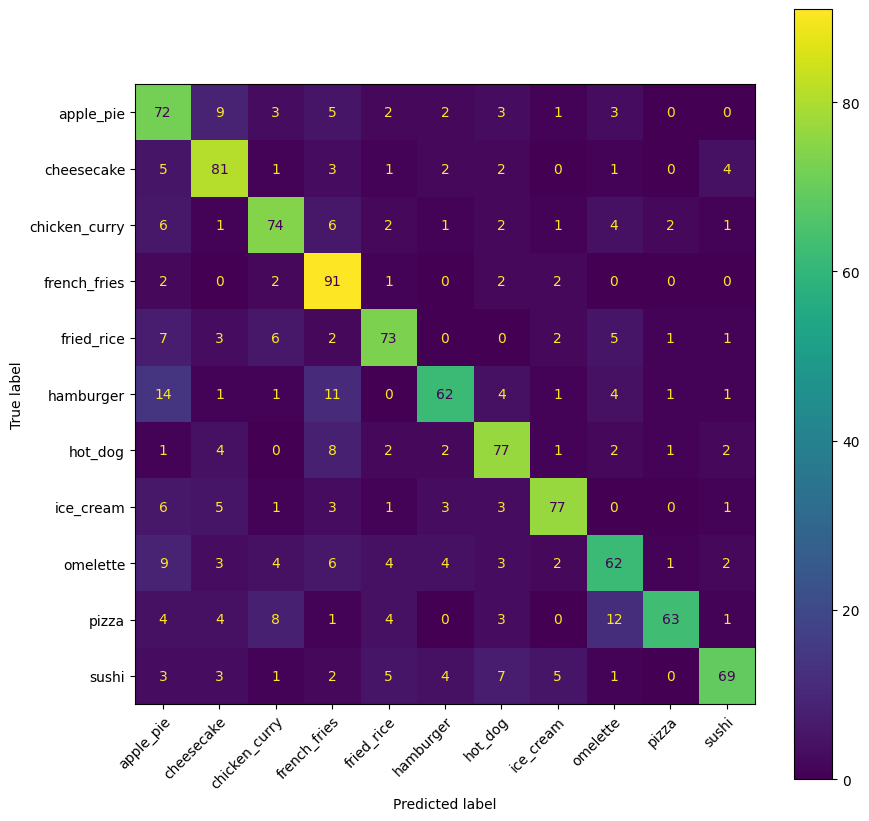

In [ ]:
cm_b0 = get_confusion_matrix(train_model_b0, test_loader_b0, device)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_b0, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

## EfficientNet-B1

The inference transforms are available at EfficientNet_B1_Weights.IMAGENET1K_V2.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[255] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[240]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

In [ ]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

In [ ]:
weights_b1 = EfficientNet_B1_Weights.IMAGENET1K_V2

test_transform_b1 = weights_b1.transforms()

train_transform_b1 = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomResizedCrop(240), # вместо center crop
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights_b1.transforms().mean,
                         std=weights_b1.transforms().std),
])

train_dataset_b1 = datasets.ImageFolder(TRAIN_DIR, transform=train_transform_b1)
test_dataset_b1 = datasets.ImageFolder(TEST_DIR, transform=test_transform_b1)

train_loader_b1 = torch.utils.data.DataLoader(train_dataset_b1, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_b1 = torch.utils.data.DataLoader(test_dataset_b1, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
model_b1 = efficientnet_b1(weights=weights_b1)

for param in model_b1.features.parameters():
    param.requires_grad = False

num_features = model_b1.classifier[1].in_features
model_b1.classifier[1] = torch.nn.Linear(num_features, len(CLASS_NAMES))

model_b1 = model_b1.to(device)

loss = nn.CrossEntropyLoss()

# обучаем только параметры, у которых requires_grad=True
optimizer_b1 = optim.Adam(filter(lambda p: p.requires_grad, model_b1.parameters()), lr=0.001)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth


100%|██████████| 30.1M/30.1M [00:00<00:00, 142MB/s]


In [ ]:
history_b1, train_model_b1 = train_model(
    model_b1,
    train_loader_b1,
    test_loader_b1,
    loss,
    optimizer_b1,
    device
)


Epoch 1/5


train: loss=1.6009 acc=0.5988 f1=0.5905
test: loss=1.0659 acc=0.7445 f1=0.7423

Epoch 2/5


train: loss=1.1012 acc=0.6871 f1=0.6838
test: loss=0.8187 acc=0.7964 f1=0.7962

Epoch 3/5


train: loss=0.9677 acc=0.7092 f1=0.7073
test: loss=0.7365 acc=0.8009 f1=0.8029

Epoch 4/5


train: loss=0.9253 acc=0.7148 f1=0.7135
test: loss=0.6828 acc=0.8136 f1=0.8146

Epoch 5/5


train: loss=0.8853 acc=0.7236 f1=0.7222
test: loss=0.6623 acc=0.8173 f1=0.8182
Обучение завершено за 6м 35с


In [ ]:
acc_b1, f1_b1, y_true_b1, y_pred_b1 = evaluate_model(train_model_b1, test_loader_b1, device)
acc_b1

0.8172727272727273

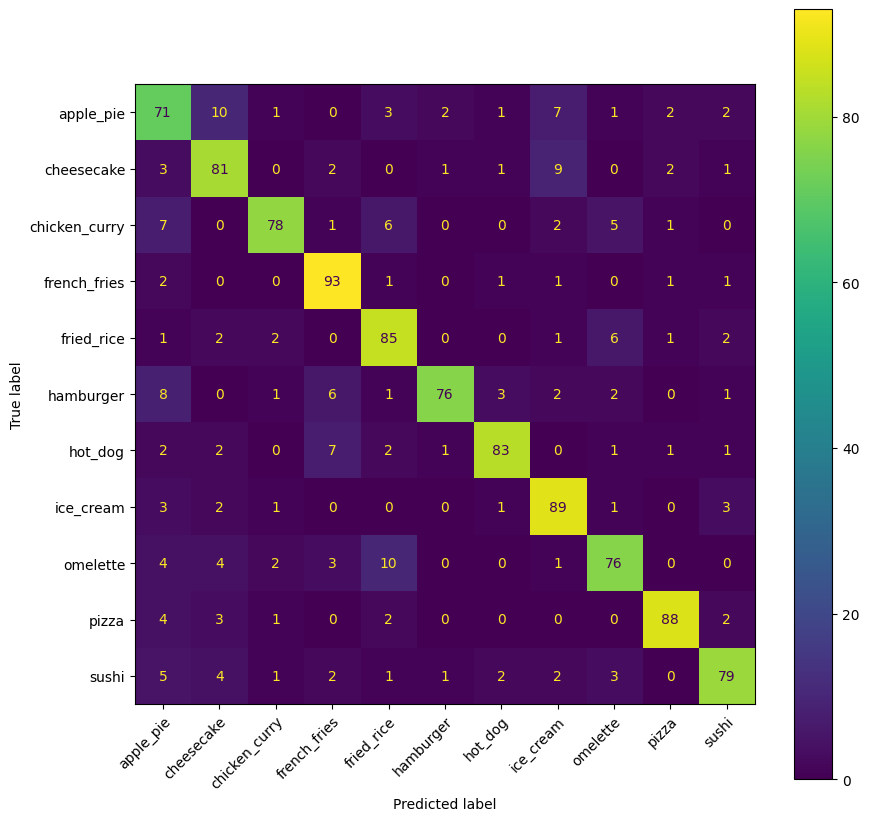

In [ ]:
cm_b1 = get_confusion_matrix(train_model_b1, test_loader_b1, device)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_b1, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

## EfficientNet-B2

The inference transforms are available at EfficientNet_B2_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[288] using interpolation=InterpolationMode.BICUBIC, followed by a central crop of crop_size=[288]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [ ]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

In [ ]:
weights_b2 = EfficientNet_B2_Weights.IMAGENET1K_V1

test_transform_b2 = weights_b2.transforms()

train_transform_b2 = transforms.Compose([
    transforms.Resize(288),
    transforms.RandomResizedCrop(288), # вместо center crop
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights_b2.transforms().mean,
                         std=weights_b2.transforms().std),
])

train_dataset_b2 = datasets.ImageFolder(TRAIN_DIR, transform=train_transform_b2)
test_dataset_b2 = datasets.ImageFolder(TEST_DIR, transform=test_transform_b2)

train_loader_b2 = torch.utils.data.DataLoader(train_dataset_b2, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_b2 = torch.utils.data.DataLoader(test_dataset_b2, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
model_b2 = efficientnet_b2(weights=weights_b2)

for param in model_b2.features.parameters():
    param.requires_grad = False

num_features = model_b2.classifier[1].in_features
model_b2.classifier[1] = torch.nn.Linear(num_features, len(CLASS_NAMES))

model_b2 = model_b2.to(device)

loss = nn.CrossEntropyLoss()

# обучаем только параметры, у которых requires_grad=True
optimizer_b2 = optim.Adam(filter(lambda p: p.requires_grad, model_b2.parameters()), lr=0.01)

In [ ]:
history_b2, train_model_b2 = train_model(
    model_b2,
    train_loader_b2,
    test_loader_b2,
    loss,
    optimizer_b2,
    device
)


Epoch 1/5


train: loss=1.3949 acc=0.5801 f1=0.5784
test: loss=1.4366 acc=0.5745 f1=0.5796

Epoch 2/5


train: loss=1.3555 acc=0.6296 f1=0.6289
test: loss=1.8153 acc=0.5355 f1=0.5456

Epoch 3/5


train: loss=1.4417 acc=0.6299 f1=0.6292
test: loss=1.7751 acc=0.5536 f1=0.5574

Epoch 4/5


train: loss=1.5014 acc=0.6304 f1=0.6298
test: loss=2.0033 acc=0.5364 f1=0.5424

Epoch 5/5


train: loss=1.4965 acc=0.6358 f1=0.6353
test: loss=1.6969 acc=0.6000 f1=0.6012
Обучение завершено за 7м 16с


In [ ]:
acc_b2, f1_b2, y_true_b2, y_pred_b2 = evaluate_model(train_model_b2, test_loader_b2, device)
acc_b2

0.6218181818181818

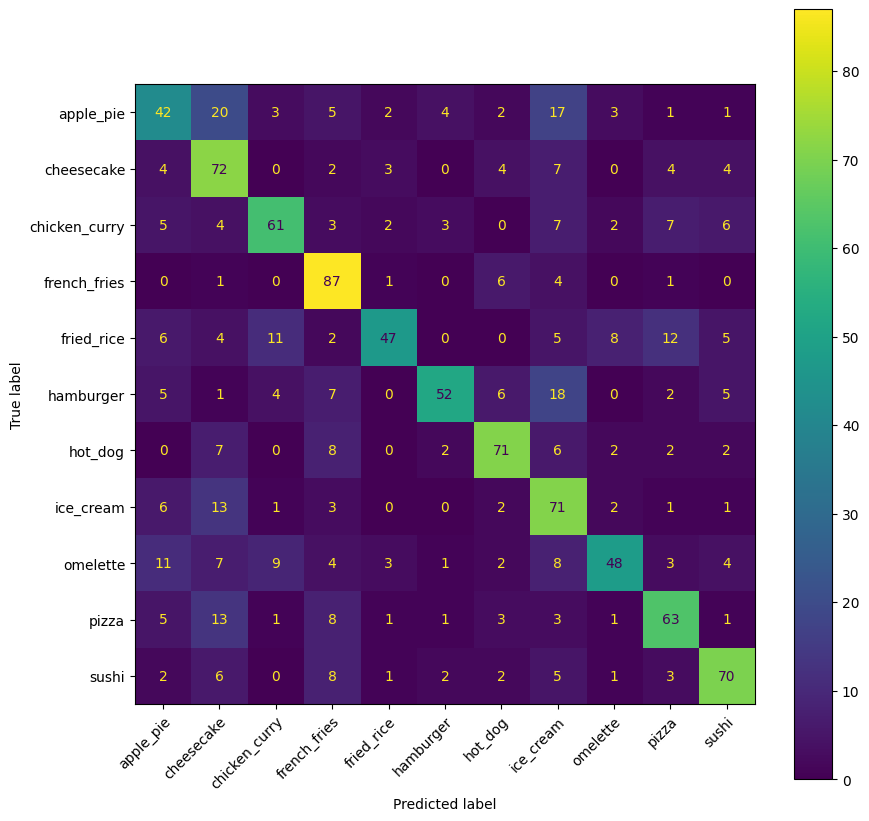

In [ ]:
cm_b2 = get_confusion_matrix(train_model_b2, test_loader_b2, device)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_b2, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

**Вывод по матрицам:**

**BO:**

Cредняя точность по диагонали: примерно 73–77 %

- Лучшие классы:
1. french_fries — 91 %
2. cheesecake, hot_dog, ice_cream — 77–81 %

- Слабые классы:
1. hamburger, omelette, sushi — 62–69 %

-Частые ошибки:
1. hamburger путается с apple_pie и french_fries
2. apple_pie и cheesecake путаются между собой
3. omelette - fried_rice - chicken_curry — типичная группа по цветам и текстуре


**B1:**

Средняя точность: 80–86 %

- Лучшие классы:
1. french_fries — 93 %
2. ice_cream — 89 %
3. pizza — 88 %

- Слабее других:
1. omelette — 76 %
2. hamburger — 76 %
3. sushi — 79 %

Ошибки стали менее выражены по разным столбцам — значит, модель лучше дифференцирует похожие блюда.
Например, apple_pie путается уже не с 3–4 классами, а в основном с cheesecake и ice_cream.

**B2:**

Средняя точность упала до 60–70 %

Резко выросло количество ошибок вне диагонали.

- Самые слабые:
1. fried_rice, hamburger, omelette — точность 47–52 %

- Относительно стабильные:
1. french_fries — 87 %
2. hot_dog — 71 %
3. ice_cream — 71 %

- Проблемы:
1. apple_pie, cheesecake, chicken_curry, fried_rice сильно путаются между собой

Модель недообучена, ей надо больше эпох.